In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
import cv2

from copy import deepcopy

# from queue import PriorityQueue

In [2]:
# CONSTANTS

ROBOT_WIDTH = 0.25
ROBOT_HEIGHT = 0.25

num_cols = math.ceil(3.0 / ROBOT_WIDTH) # field is 3m x 3m
num_rows = math.ceil(3.0 / ROBOT_HEIGHT)

world = np.zeros((num_rows, num_cols)) # each cell is 0.25m x 0.25m


world.shape

(12, 12)

In [3]:
OBSTACLE_WIDTH = 0.5
OBSTACLE_HEIGHT = 0.5

In [4]:
# set obstacle in map
world[int(world.shape[0] / 2)-1:int(world.shape[0] / 2)+1,int(world.shape[1] / 2)-1:int(world.shape[1] / 2)+1]  = 1

In [5]:
world

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [6]:
class PriorityQueue(object):
    def __init__(self):
        self.queue = []
 
    def __str__(self):
        return ' '.join([str(i) for i in self.queue])
 
    # for checking if the queue is empty
    def isEmpty(self):
        return len(self.queue) == 0
 
    # for inserting an element in the queue
    def put(self, data):
        self.queue.append(data)
 
    # for popping an element based on Priority
    def get(self):
        try:
            max_val = 0
            for i in range(len(self.queue)):
                if self.queue[i][0] < self.queue[max_val][0]:
                    max_val = i
            item = self.queue[max_val]
            del self.queue[max_val]
            return item
        except IndexError:
            print()
            exit()

In [7]:
class Node:
    def __init__(self, x, y):
        # numpy array is indexed by arr[y, x]
        self.x = x
        self.y = y
        self.parent = None
        self.f = 0
        self.g = 0
    
    def __str__(self):
        return "x: {} y: {}".format(self.x, self.y)
    
    def set_parent(self, n):
        self.parent = n
        
    def get_parent(self):
        return self.parent
    
    def set_f(self, f):
        self.f = f
        
    def get_f(self):
        return self.f
        
    def set_g(self, g):
        self.g = g
        
    def get_g(self):
        return self.g
    
    def get_x(self):
        return self.x
    
    def get_y(self):
        return self.y
    
    def __eq__(self, n):
        return self.x == n.get_x() and self.y == n.get_y()
    
class Map:
    def __init__(self, world_map):
        self.map = world_map # 2D numpy boolean array, 1 means occupied
        
    def get_neighbors(self, n):
        """Returns unoccupied neighbor cells in the map for a given node"""
        x = n.get_x()
        y = n.get_y()
        possible_neighbors = [
            Node(x, y - 1),
            Node(x, y + 1),
            Node(x - 1, y),
            Node(x + 1, y),
            Node(x - 1, y - 1),
            Node(x - 1, y + 1),
            Node(x + 1, y - 1),
            Node(x + 1, y + 1),
        ]
        valid_neighbors = [node for node in possible_neighbors if node.get_x() >= 0 and node.get_x() < self.map.shape[1]
                              and node.get_y() >= 0 and node.get_y() < self.map.shape[0]
                              and self.map[node.get_y(), node.get_x()] == 0
                          ]
        return valid_neighbors

In [8]:
def h(n, g):
    """
    n and g are tuple of (row, col) coordinates in world map grid
    returns euclidean distance in meters between two coordinates in map grid
    """
    y1 = n.get_y()
    x1 = n.get_x()
    
    y2 = g.get_y()
    x2 = g.get_x()
    
    y1 *= ROBOT_HEIGHT
    y2 *= ROBOT_HEIGHT
    
    x1 *= ROBOT_WIDTH
    x2 *= ROBOT_WIDTH
    
    d = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    return d

def a_star(start, goal, mapp):
    """start and goal are both of type Node"""
    open_lst = PriorityQueue()
    close_lst = []
    
    open_lst.put((start.f, start))
    
    while not open_lst.isEmpty():
        f_n, n = open_lst.get()
        succs = mapp.get_neighbors(n)
        for suc in succs:
            suc.set_parent(n)
            
            if suc.x == goal.x and suc.y == goal.y:
                # goal is found
                return suc
            
            # compute f of node
            suc.set_g(n.get_g() + h(n, suc))
            suc.set_f(suc.get_g() + h(suc, goal))
            
            # check if successor should be skipped
            skip = False
            all_opens = open_lst.queue
            for op in all_opens:
                if suc == op[1] and suc.get_f() >= op[0]:
                    skip = True
                    
            for cl in close_lst:
                if suc == cl and cl.get_f() < suc.get_f():
                    skip = True
            
            if not skip:
                open_lst.put((suc.get_f(), suc))
                
        close_lst.append(n)
    print("no path possible")

In [9]:
s_n = Node(11, 11)
g_n = Node(0, 0)
mapp = Map(world)

In [10]:
final = a_star(s_n, g_n, mapp)

In [11]:
cur = deepcopy(final)
path = []
while cur is not None:
    path.append(cur)
    cur = cur.parent

In [12]:
for elem in path:
    print(elem)

x: 0 y: 0
x: 1 y: 1
x: 2 y: 1
x: 3 y: 1
x: 4 y: 2
x: 5 y: 3
x: 6 y: 4
x: 7 y: 5
x: 7 y: 6
x: 7 y: 7
x: 8 y: 8
x: 9 y: 9
x: 10 y: 10
x: 11 y: 11


In [13]:
xs = [elem.get_x() for elem in path]
ys = [elem.get_y() for elem in path]

In [14]:
world_plot = world.copy()
world_plot[-1,-1] = 1
world_plot[0, 0] = 1

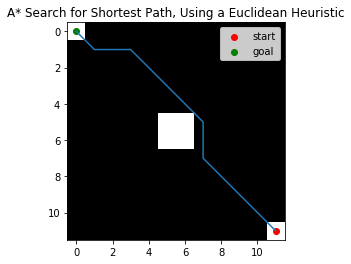

In [15]:
plt.imshow(world_plot, cmap='gray')
plt.scatter(np.array([11]), np.array([11]), color='r', label='start')
plt.scatter(np.array([0]), np.array([0]), color='g', label='goal')
plt.gca().add_line(plt.Line2D(xs,ys))
plt.title("A* Search for Shortest Path, Using a Euclidean Heuristic")
plt.legend()

In [16]:
def coordinate_to_waypoints(coords):
    """
    turns matrix i=y, j=x values into robot waypoints
    """
    # world is 12 x 12
    waypoints = []
    for elem in coords:
        # x is correct, but y is positive in opposite direction
        w_x, w_y = elem
        w_y = world.shape[0] - 1 - w_y
        waypoint_x = w_x*(ROBOT_WIDTH) + (ROBOT_WIDTH/2)
        waypoint_y = w_y *(ROBOT_HEIGHT) + (ROBOT_HEIGHT/2)
        waypoints.append([waypoint_x, waypoint_y])
    return waypoints

In [19]:
coordinates = np.array(list(zip(xs, ys)))[::-1]

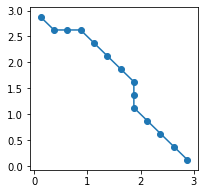

In [21]:
waypoints = np.array(coordinate_to_waypoints(coordinates))
obstacle_waypoints = coordinate_to_waypoints([[5, 5], [5, 6], [6, 5], [6, 6]])

plt.figure(figsize=(3, 3))
plt.plot(waypoints[:, 0], waypoints[:, 1])
plt.scatter(waypoints[:, 0], waypoints[:, 1])

In [ ]:
def compress_waypoints(wayps):
    """
    turns sequence of waypoints into smaller list
    by considering continuity in slope
    """
    denom = (wayps[1][0] - wayps[0][0])
    if denom == 0:
        prev_slope = np.inf
    else:
        prev_slope = (wayps[1][1] - wayps[0][1]) / denom
    condensed = [wayps[0]]
    
    for k in range(1, len(wayps)-1):
        wp = wayps[k]
        denom = (wayps[k+1][0] - wp[0])
        if denom == 0:
            slope_with_next = np.inf
        else:
            slope_with_next = (wayps[k+1][1] - wp[1]) / denom
        
        if slope_with_next != prev_slope:
            condensed.append(wp)
        prev_slope = slope_with_next
    condensed.append(wayps[-1])
    return np.array(condensed)

In [ ]:
condensed_wps = compress_waypoints(waypoints)

plt.figure(figsize=(3,3))
plt.plot(condensed_wps[:, 0], condensed_wps[:, 1])
plt.scatter(condensed_wps[:, 0], condensed_wps[:, 1])

In [ ]:
# add theta dimension to waypoints
condensed_wps = np.hstack([condensed_wps, np.zeros((condensed_wps.shape[0], 1))])
condensed_wps

In [ ]:
def theta_to_next(wps):
    """
    returns theta for each waypoint which will point to
    the next waypoint
    """
    thetas = []
    for k in range(len(wps)-1):
        dy = wps[k+1][1] - wps[k][1]
        dx = wps[k+1][0] - wps[k][0]
        theta = math.atan2(dy, dx)
        thetas.append(theta)
    return np.array(thetas)

In [ ]:
# modify theta dimensions for smoother motion 
final_wps = condensed_wps.copy()
final_wps[:-1, 2] = theta_to_next(final_wps[:])

In [ ]:
 # no change in theta for last waypoint necessary
final_wps[-1, 2] = final_wps[-2, 2]

In [ ]:
final_wps

In [ ]:
plt.figure(figsize=(3, 3))
axes = plt.axes()
plt.plot(final_wps[:, 0], final_wps[:, 1])
plt.scatter(final_wps[:, 0], final_wps[:, 1])
for k in range(len(final_wps)):
#     if k == 0:
    x, y, theta = final_wps[k]
    theta = (theta + 2*np.pi) % (2*np.pi)
    y_x = np.tan(theta)
    if theta == np.pi/2:
        d_x = 0.0001
        d_y = 0.1
    elif theta == 3*np.pi/2:
        d_x = 0.0001
        d_y = -0.1
    elif theta == np.pi:
        d_x = -0.1
        d_y = 0.0001
    elif theta == 2*np.pi:
        d_x = 0.1
        d_y = 0.0001
    elif theta < np.pi/2:
        d_x = 0.1 # q1
        d_y = y_x * d_x
    elif theta > np.pi/2 and theta < np.pi:
        # q2
        d_x = -0.1
        d_y = y_x * d_x
    elif theta > np.pi and theta < 3*np.pi/2:
        d_x = -0.1 # q3
        d_y = y_x * d_x
    else:
        d_x = 0.1
        d_y = y_x * d_x

    plt.arrow(x, y, d_x, d_y, head_width=0.1, head_length = 0.1)
